<a href="https://colab.research.google.com/github/step-cheng/cs496_gradienttheory/blob/main/CS496_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [54]:
train_set = MNIST('./', download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  ]), train=True)


test_set = MNIST('./', download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  ]), train=False)


In [55]:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=100,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=10000,
    shuffle=False
)
device = torch.device('cuda')

In [56]:
class Model:
  def __init__(self, dim, num_layers, norm):
    # change to have a param dict
    self.num_hlayers = num_layers - 2
    self.norm=norm
    self.p = {}
    self.p['fce_w'] = torch.randn(784,100, requires_grad=True, device=device)
    self.p['fce_b'] = torch.randn(100, requires_grad=True, device=device)
    self.p['fcd_w'] = torch.randn(100,10, requires_grad=True, device=device)
    self.p['fcd_b'] = torch.randn(10, requires_grad=True, device=device)
    for i in range(self.num_hlayers):
      self.p[f'fc{i}_w'] = torch.randn(100,100, requires_grad=True, device=device)
      self.p[f'fc{i}_b'] = torch.randn(100, requires_grad=True, device=device)

  def relu(self, x):
    return x.clamp(min=0)

  def normalize(self, x):
    means = torch.mean(x, dim=-1, keepdim=True)
    stds = torch.std(x, dim=-1, keepdim=True)
    return (x - means) / (stds + 1e-7)

  def __call__(self, x):
    x = x.flatten(start_dim=1)
    x = self.normalize(x) if self.norm else x
    h = x @ self.p['fce_w'] + self.p['fce_b']
    h = self.relu(h)
    for i in range(self.num_hlayers):
      h = self.normalize(h) if self.norm else h
      h = h @ self.p[f'fc{i}_w'] + self.p[f'fc{i}_b']
      h = self.relu(h)
    h = self.normalize(h) if self.norm else h
    out = h @ self.p['fcd_w'] + self.p['fcd_b']
    return out

In [57]:
class Agent:
  def __init__(self, dim, layers, norm, train_loader, test_loader, lr):
    self.model = Model(dim, layers, norm)
    self.ce_loss = torch.nn.CrossEntropyLoss()
    self.lr = lr
    self.train_loader = train_loader
    self.test_loader = test_loader

  def SGD(self, out, y):
    with torch.no_grad():
      for l in self.model.p:
        self.model.p[l] -= self.model.p[l].grad * self.lr

  def zero_grads(self):
    for l in self.model.p:
      self.model.p[l].grad.zero_()

  def train(self):
    for x, y in self.train_loader:
      x = x.to(device)
      y = y.to(device)
      out = self.model(x)
      loss = self.ce_loss(out, y)
      loss.backward()
      self.SGD(out, y)
      self.zero_grads()

  def find_matches(self, out, y):
    preds = torch.argmax(out, dim=-1)
    matches = torch.eq(preds, y).sum().item()
    return matches

  def test(self):
    with torch.no_grad():
      total_loss = 0
      total_correct = 0
      total_samples = 0

      for x, y in self.test_loader:
        x = x.to(device)
        y = y.to(device)
        out = self.model(x)
        loss = self.ce_loss(out, y)
        bsz = out.shape[0]

        total_loss += loss.item() * bsz
        total_correct += self.find_matches(out, y)
        total_samples += bsz

    final_loss = total_loss / total_samples
    final_accuracy = total_correct / total_samples
    print(f'Loss: {final_loss}')
    print(f'Accuracy: {final_accuracy}')

    return final_loss, final_accuracy



In [58]:
# Experiment 1

config = {
    'dim' : 100,
    'layers' : 2,
    'train_loader' : train_loader,
    'test_loader' : test_loader,
    'lr' : 1,
    'norm' : False,
}
agent = Agent(**config)

epochs = 10
losses = []
accs = []
for i in range(epochs):
  print('Epoch', i)
  loss, acc = agent.test()
  losses.append(loss)
  accs.append(acc)

  agent.train()


Epoch 0
Loss: 98.49726867675781
Accuracy: 0.1238
Epoch 1
Loss: 0.5321667194366455
Accuracy: 0.8579
Epoch 2
Loss: 0.4361081123352051
Accuracy: 0.8843
Epoch 3
Loss: 0.390223890542984
Accuracy: 0.9014
Epoch 4
Loss: 0.3536732792854309
Accuracy: 0.9089
Epoch 5
Loss: 0.3082968592643738
Accuracy: 0.9211
Epoch 6
Loss: 0.3307949900627136
Accuracy: 0.9208
Epoch 7
Loss: 0.30264079570770264
Accuracy: 0.9235
Epoch 8
Loss: 0.2880219519138336
Accuracy: 0.9275
Epoch 9
Loss: 0.28324946761131287
Accuracy: 0.9313


Text(0.5, 1.0, 'Loss')

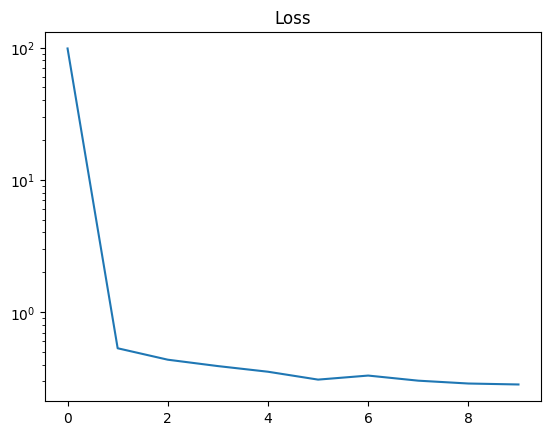

In [59]:
plt.plot(range(epochs), losses)
plt.yscale('log')
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

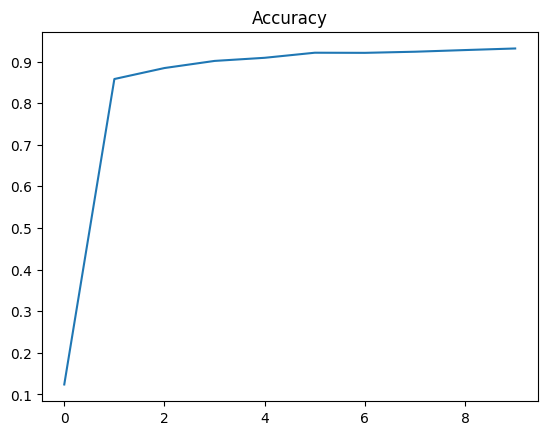

In [60]:
plt.plot(range(epochs), accs)
plt.title('Accuracy')

In [67]:
# Experiment 2
config = {
    'dim' : 100,
    'layers' : 10,
    'train_loader' : train_loader,
    'test_loader' : test_loader,
    'lr' : 0.001,
    'norm' : False,
}
agent = Agent(**config)

epochs = 10
losses = []
accs = []
for i in range(epochs):
  print('Epoch', i)
  loss, acc = agent.test()
  losses.append(loss)
  accs.append(acc)

  agent.train()

Epoch 0
Loss: 265208256.0
Accuracy: 0.1335
Epoch 1
Loss: nan
Accuracy: 0.098
Epoch 2
Loss: nan
Accuracy: 0.098
Epoch 3
Loss: nan
Accuracy: 0.098
Epoch 4
Loss: nan
Accuracy: 0.098
Epoch 5
Loss: nan
Accuracy: 0.098
Epoch 6
Loss: nan
Accuracy: 0.098
Epoch 7
Loss: nan
Accuracy: 0.098
Epoch 8
Loss: nan
Accuracy: 0.098
Epoch 9
Loss: nan
Accuracy: 0.098


Text(0.5, 1.0, 'Loss')

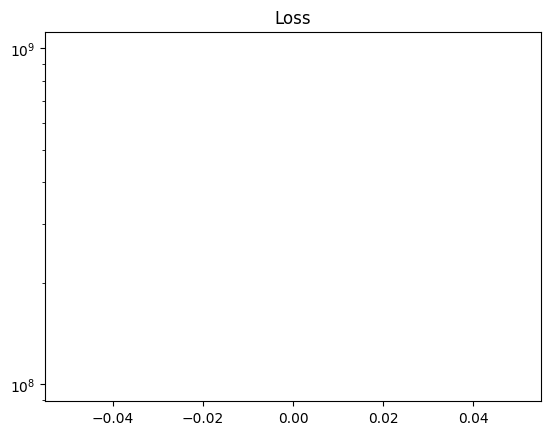

In [68]:
plt.plot(range(epochs), losses)
plt.yscale('log')
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

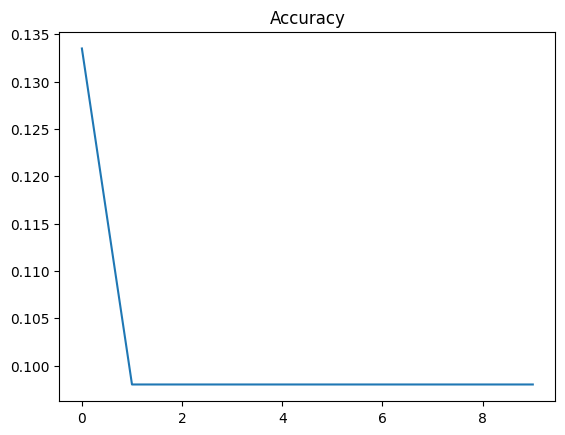

In [69]:
plt.plot(range(epochs), accs)
plt.title('Accuracy')

In [64]:
# Experiment 3
config = {
    'dim' : 100,
    'layers' : 10,
    'train_loader' : train_loader,
    'test_loader' : test_loader,
    'lr' : 1,
    'norm' : True,
}
agent = Agent(**config)

epochs = 10
losses = []
accs = []
for i in range(epochs):
  print('Epoch', i)
  loss, acc = agent.test()
  losses.append(loss)
  accs.append(acc)

  agent.train()

Epoch 0
Loss: 15.448948860168457
Accuracy: 0.0874
Epoch 1
Loss: 0.3560101091861725
Accuracy: 0.9026
Epoch 2
Loss: 0.2267964780330658
Accuracy: 0.9358
Epoch 3
Loss: 0.22441740334033966
Accuracy: 0.9385
Epoch 4
Loss: 0.21185603737831116
Accuracy: 0.9449
Epoch 5
Loss: 0.17743311822414398
Accuracy: 0.9487
Epoch 6
Loss: 0.17950882017612457
Accuracy: 0.952
Epoch 7
Loss: 0.1908424347639084
Accuracy: 0.9504
Epoch 8
Loss: 0.186933234333992
Accuracy: 0.952
Epoch 9
Loss: 0.1747194230556488
Accuracy: 0.9563


Text(0.5, 1.0, 'Loss')

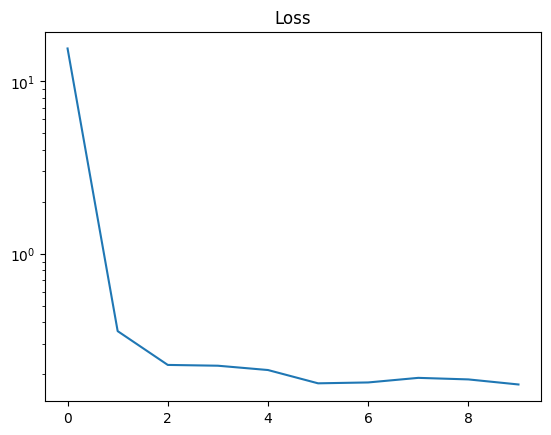

In [65]:
plt.plot(range(epochs), losses)
plt.yscale('log')
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

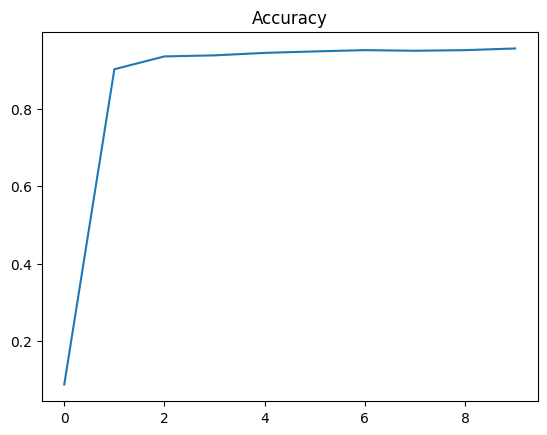

In [66]:
plt.plot(range(epochs), accs)
plt.title('Accuracy')

## Discussion
The two layer network performed well, with an accuracy of around 92%. This is because the MNIST dataset is relatively simple, so having two layers is sufficient. Each target class contains similar samples, and the data is binary, making it less information dense.

The ten layer network without normalization performed poorly. Because there are many layers in a ten layer network, the variance of the input increases in magnitude as the input travels through each layer. Thus, when the gradients are calculated for each layer, the earlier layers may have exploding or vanishing gradients because the gradients are the products of many later weight matrices. For example, if the input before the ReLU activation is mostly negative values, then the activation output will be mostly zeros. Thus, the gradients at that layer and earlier layers will be zero, which means no learning takes place.

Exploding and vanishing gradients are avoided when the input is normalized with z-score normalization at each layer of the network. Since the input is used to calculate the gradients for the weights, scaling the input to a consistent range ensures that gradients are not too large or small. This is why the ten layer network with normalization performed well, with an accuracy of around 95%.